In [1]:
# use these magic spells to update your classes methods on-the-fly as you edit them:
%reload_ext autoreload
%autoreload 2
from pprint import pprint
from IPython.core.display import display, HTML, Markdown
import ipywidgets as widgets
# %run includeme.ipynb # include a notebook from this same directory
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_21026/3813857106.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [2]:
# common libs
import math, os, io, json, cv2, random, logging, datetime
import numpy as np
# torch
import torch
from torchvision import transforms
# images
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# helpers
def cv2_imshow(img):
    img2 = img[:,:,::-1]
    plt.figure(figsize=(12, 9))
    plt.axis('off')
    plt.imshow(img2)
    plt.show()

In [4]:
## *** Detectron imports ***
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
# CompressAI-Vision
from compressai_vision.conversion import FO2DetectronDataset # convert fiftyone dataset to Detectron2 dataset
from compressai_vision.conversion import detectron251 # convert Detectron2 results to fiftyone format
from compressai_vision.evaluation.fo import annexPredictions # annex predictions from

In [6]:
# fiftyone
import fiftyone as fo
import fiftyone.zoo as foz

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [8]:
print("torch:", torch.__version__, "/ cuda:", torch.version.cuda, "/ detectron2:", detectron2.__version__)

torch: 1.9.1+cu102 / cuda: 10.2 / detectron2: 0.6


Pick up correct Detectron2 model

In [9]:
## MODEL A
model_name="COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
## look here:
## https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md#faster-r-cnn

## MODEL B
# model_name="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

In [10]:
# cfg encapsulates the model architecture & weights, also threshold parameter, metadata, etc.
cfg = get_cfg()
cfg.MODEL.DEVICE=device
# load config from a file:
cfg.merge_from_file(model_zoo.get_config_file(model_name))
# DO NOT TOUCH THRESHOLD WHEN DOING EVALUATION:
# too big a threshold will cut the smallest values & affect the precision(recall) curves & evaluation results
# the default value is 0.05
# value of 0.01 saturates the results (they don't change at lower values)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# get weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
print("expected input colorspace:", cfg.INPUT.FORMAT)
print("loaded datasets:", cfg.DATASETS)
model_dataset=cfg.DATASETS.TRAIN[0]
print("model was trained with", model_dataset)
model_meta=MetadataCatalog.get(model_dataset)

expected input colorspace: BGR
loaded datasets: PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
PROPOSAL_FILES_TEST: ()
PROPOSAL_FILES_TRAIN: ()
TEST: ('coco_2017_val',)
TRAIN: ('coco_2017_train',)
model was trained with coco_2017_train


In [11]:
predictor = DefaultPredictor(cfg)

[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...
URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl cached in /home/sampsa/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl
Reading a file from 'Detectron2 Model Zoo'


Get a handle to the dataset created in previous notebooks

In [12]:
dataset = fo.load_dataset("mpeg_vcm-detection")

In [13]:
dataset

Name:        mpeg_vcm-detection
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    detections:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    open_images_id:  fiftyone.core.fields.StringField

If needed, we can go from fiftyone dataset to Detectron2 dataset:

In [14]:
detectron_dataset=FO2DetectronDataset(fo_dataset=dataset, model_catids=model_meta.thing_classes)

Pick a sample:

In [15]:
d=detectron_dataset[3]

We can visualize that sample also with Detectron2 library tools (although we'd prefer fiftyone with ``fo.launch_app(dataset)``):

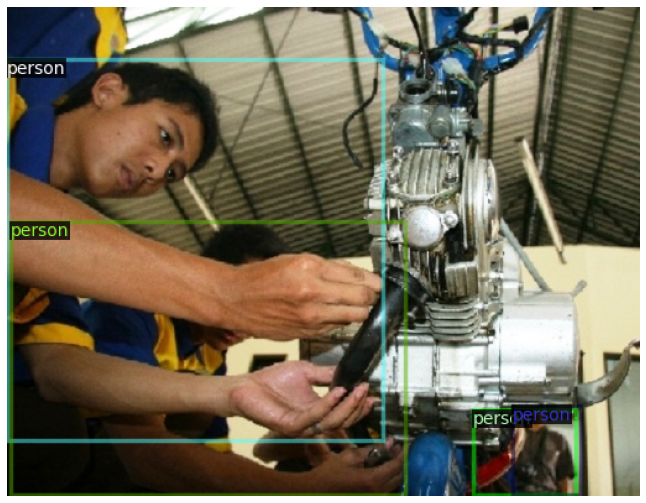

In [16]:
# visualize with Detectron2 tools only
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=model_meta, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

Let's try the Detectron2 predictor:

In [17]:
res=predictor(img)

/home/sampsa/silo/interdigital/venv_all/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


We can convert from Detectron2 format to fiftyone detection objects:

In [18]:
dets=detectron251(res, model_catids=model_meta.thing_classes) # process involves going from class indexes (ints) to class labels (strings)

In [19]:
dets

<Detections: {
    'detections': BaseList([
        <Detection: {
            'id': '6310bde39a52f207bd793582',
            'attributes': BaseDict({}),
            'tags': BaseList([]),
            'label': 'person',
            'bounding_box': BaseList([
                0.009324110113084316,
                0.07061359169804884,
                0.636555933393538,
                0.9101487120042683,
            ]),
            'mask': None,
            'confidence': 0.9894514679908752,
            'index': None,
        }>,
        <Detection: {
            'id': '6310bde39a52f207bd793583',
            'attributes': BaseDict({}),
            'tags': BaseList([]),
            'label': 'person',
            'bounding_box': BaseList([
                0.7662928700447083,
                0.8120538199233528,
                0.13444077968597412,
                0.18774914350665983,
            ]),
            'mask': None,
            'confidence': 0.9372856616973877,
            'index': None

Let's run each image in the fiftyone dataset through the predictor.  Results from the predictor will be annexed to the same fiftyone dataset.

In [20]:
dataset = fo.load_dataset("mpeg_vcm-detection-dummy") # use the dummy dataset for testing/debugging

Detectron prediction results are saved during the run into the fiftyone (mongodb) database. Let's define a unique name for the sample field where the detectron results are saved:

In [21]:
predictor_field='detectron-{0:%Y-%m-%d-%H-%M-%S-%f}'.format(datetime.datetime.now())
print(predictor_field)

detectron-2022-09-01-17-12-52-069878


In [22]:
annexPredictions(predictor=predictor, fo_dataset=dataset, predictor_field=predictor_field)

 100% |█████████████████████| 1/1 [6.0s elapsed, 0s remaining, 0.2 samples/s] 


After that one, the dataset looks slightly different

In [23]:
sample=dataset.first()

In [24]:
## this one was there to begin with
# sample["detections"]

In [25]:
## this one has been added by running the Detectron2 predictor:
#sample[predictor_field]

Each sample in the dataset contains "detections" (ground truths) and "detectron-unique-datetime-id]" (predicted values).  Now we can run the OpenImageV6 evaluation protocol on the dataset that compares the two:

In [26]:
results = dataset.evaluate_detections(
    predictor_field,
    gt_field="detections",
    method="open-images",
    pos_label_field="positive_labels",
    neg_label_field="negative_labels",
    expand_pred_hierarchy=False,
    expand_gt_hierarchy=False
)

Evaluating detections...
 100% |█████████████████████| 1/1 [26.3ms elapsed, 0s remaining, 38.0 samples/s] 


After the evaluation we can (and should!) remove the detectron results from the database:

In [27]:
dataset.delete_sample_fields(predictor_field)

OpenImageV6 evaluation protocol mAP:

In [28]:
results.mAP()

1.0

Per class mAP:

In [29]:
classes = dataset.distinct(
    "detections.detections.label"
)
for class_ in classes:
    print(class_, results.mAP([class_]))

airplane 1.0
